# Fine-Tuning DistilBERT for Emotion Classification

In this notebook, I’ll walk through the process of fine-tuning a transformer model (`DistilBERT`) for emotion classification.

We'll leverage pre-trained models from the **Hugging Face** library and fine-tune them on the Emotions Dataset (available [here](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)). This dataset contains labeled text samples spanning six emotion categories: **sadness, joy, love, anger, fear, and surprise**.

Throughout this notebook, we will cover:

1. Preprocessing text for model training and inference,
2. Setting up an efficient training pipeline,
3. Evaluating model performance using accuracy, F1 score, and confusion matrices,
4. Fine-tuning transformer models for optimal performance on emotional classification.

By the end of this notebook, you’ll have a trained model capable of classifying emotions from text with high accuracy.



In [1]:
# Import necessary libraries
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    logging,
    pipeline,
)
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import pytz
import seaborn as sns
import shap
import torch
import warnings

# Ignore warnings
logging.set_verbosity_error()
warnings.filterwarnings("ignore")


In [2]:
# Check GPU Availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
plt.style.use("ggplot")

# 1. Load Data
Here’s how you can download the dataset directly from Kaggle and load it into your environment.

### Download Dataset from Kaggle:
I found a dataset on Kaggle for this task. You can follow these steps to download the dataset:

1. Visit the dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
2. Click the "Download" button (usually located at the top-right). The dataset will be downloaded as a ZIP file to your computer.
3. Extract the ZIP file to a folder of your choice.
4. Make sure to adjust the data_path variable to point to where the dataset was extracted.

In [4]:
!ls sample_data/emotions_dataset/


ls: cannot access 'sample_data/emotions_dataset/': No such file or directory


In [5]:
# Set the path to the dataset
path = "./sample_data/emotions_dataset/"

# 2. Parse .txt Files
The dataset consists of .txt files, where each line follows the format: text; emotion. We need to parse these files correctly using Python's pandas library for better manipulation.

Steps to Parse the Text File:
1. Read the Text File: Open and read the file line by line.
2. Parse Each Line: Split the line by the semicolon (;) delimiter to extract the text and the emotion.
3. Store in a DataFrame: Store the parsed data into a pandas DataFrame for easier processing.

In [6]:
def parse_emotion_file(file_path):
    """
    Parses a text file with each line in the format: {text; emotion}
    and returns a pandas DataFrame with 'text' and 'emotion' columns.

    Args:
    - file_path (str): Path to the .txt file to be parsed

    Returns:
    - df (pd.DataFrame): DataFrame containing 'text' and 'emotion' columns
    """
    texts = []
    emotions = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                # Split each line by the semicolon separator
                text, emotion = line.strip().split(';')
                texts.append(text)
                emotions.append(emotion)
            except ValueError:
                # Handle lines that do not match the expected format
                continue

    # Return as a pandas DataFrame
    df = pd.DataFrame({'text': texts, 'emotion': emotions})
    return df

In [8]:
# Parse the training, test, and validation datasets
train_df = parse_emotion_file(os.path.join(path, "train.txt"))
test_df = parse_emotion_file(os.path.join(path, "test.txt"))
val_df = parse_emotion_file(os.path.join(path, "val.txt"))

In [9]:
print("Train Dataset:")
print(f"Shape: {train_df.shape}")
print(train_df.head())

print("\nTest Dataset:")
print(f"Shape: {test_df.shape}")
print(test_df.head())

print("\nValidation Dataset:")
print(f"Shape: {val_df.shape}")
print(val_df.head())


Train Dataset:
Shape: (16000, 2)
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

Test Dataset:
Shape: (2000, 2)
                                                text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness

Validation Dataset:
Shape: (2000, 2)
                                                text  emotion
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still loo

# 3. Preprocess Data
Next, we analyze the distribution of emotion labels in the dataset. This helps us understand the dataset better and how to handle any imbalances.

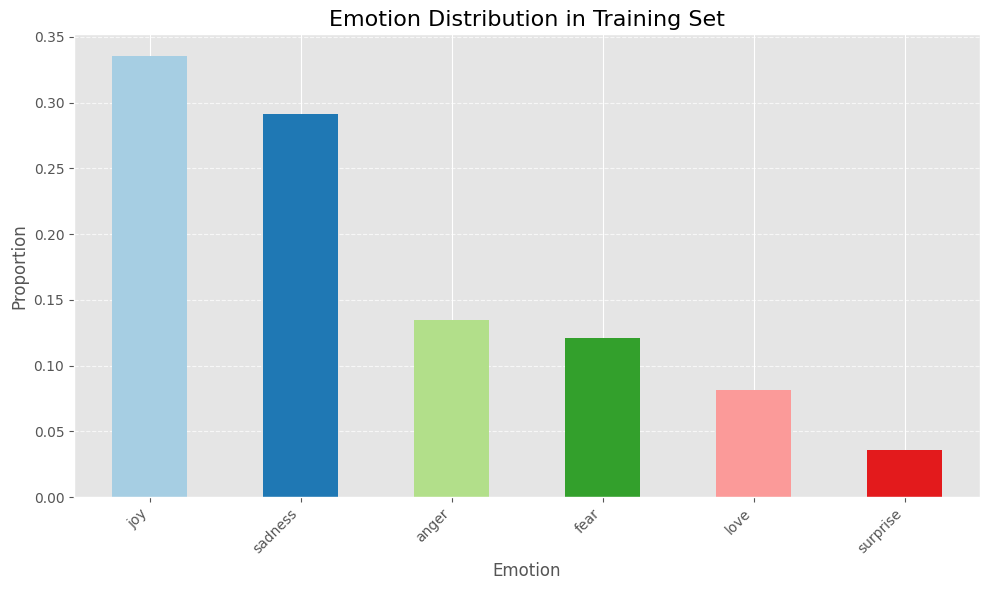

In [10]:
# Plot the distribution of emotions
ax = train_df["emotion"].value_counts(normalize=True).plot(
    kind="bar",
    figsize=(10, 6),
    color=plt.cm.Paired.colors  # Using a distinct color map
)

# Add title and labels
ax.set_title('Emotion Distribution in Training Set', fontsize=16)
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Show gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [11]:
# Get the unique emotion labels from the 'emotion' column in the training DataFrame
labels = train_df["emotion"].unique()

# Create label-to-id and id-to-label mappings
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}

# Print the mappings
print(label2id)
print(id2label)

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}
{0: 'sadness', 1: 'anger', 2: 'love', 3: 'surprise', 4: 'fear', 5: 'joy'}


# 4. Load Pre-trained Model
Now, let's load a pre-trained transformer model (`DistilBERT` in this case) along with its tokenizer. This model will be used for emotion classification.

I chose to use DistilBERT, because it is a smaller, faster, and more efficient variant of the BERT model.

DistilBERT retains 97% of BERT’s language understanding while having 60% fewer parameters, making it computationally more efficient.

This trade-off between efficiency and performance makes it an ideal choice for fine-tuning on sentiment-related tasks.

In [12]:
# Define the model path for DistilBERT
model_name = "distilbert-base-uncased"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 5. Tokenize Dataset
We need to tokenize the text data to convert it into the format required by the transformer model. Below is a function that handles this process.

In [13]:
def preprocess_function(df, label2id):
    """
    Tokenizes text data and transforms labels into numerical IDs.

    Args:
        df (dict or pandas.Series): A dictionary-like object containing "text" and "emotion" fields.
        label2id (dict): A mapping from emotion labels to numerical IDs.

    Returns:
        dict: A dictionary containing:
              - "input_ids": Encoded token sequences
              - "attention_mask": Mask to indicate padding tokens
              - "label": Numerical labels for classification

    Example usage:
        train_dataset = train_dataset.map(lambda x: preprocess_function(x, tokenizer, label2id), batched=True)
    """
    tokenized_inputs = tokenizer(
        df["text"],
        padding="longest",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    tokenized_inputs["label"] = [label2id.get(emotion, -1) for emotion in df["emotion"]]
    return tokenized_inputs


In [14]:
# Convert the DataFrames to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply the 'preprocess_function' to tokenize text data and transform labels
train_dataset = train_dataset.map(lambda x: preprocess_function(x, label2id), batched=True)
val_dataset = val_dataset.map(lambda x: preprocess_function(x, label2id), batched=True)
test_dataset = test_dataset.map(lambda x: preprocess_function(x, label2id), batched=True)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

With the data loaded and preprocessed, and the model set up for sequence classification, we can move forward with training and evaluating the model.

From here, we can fine-tune the model to improve its performance and analyze its results.

## Train Model

### Predict Using Pretrained DistilBERT Model

Let's start by predicting using the base DistilBERT model (`distilbert-base-uncased`) without finet-tuning to see its baseline performance.

In [15]:
print(model_name)

distilbert-base-uncased


In [16]:
# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [17]:
def compute_metrics(p):
    """
    Computes accuracy, F1 score, precision, and recall metrics for multiclass classification.

    Args:
    p (tuple): Tuple containing predictions and labels.

    Returns:
    dict: Dictionary with accuracy, F1 score, precision, and recall metrics, using weighted averaging
          to account for class imbalance in multiclass classification tasks.
    """
    logits, labels = p

    # Convert logits to probabilities using softmax (PyTorch)
    softmax = torch.nn.Softmax(dim=1)
    probs = softmax(torch.tensor(logits))

    # Convert logits to predicted class labels
    preds = probs.argmax(axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),  # Accuracy metric
        "f1_score": f1_score(labels, preds, average='weighted'),  # F1 score with weighted average for imbalanced data
        "precision": precision_score(labels, preds, average='weighted'),  # Precision score with weighted average
        "recall": recall_score(labels, preds, average='weighted'),  # Recall score with weighted average
        "auc_score": roc_auc_score(labels, probs, average="macro", multi_class="ovr")
    }

In [18]:
# Initialize a Trainer instance for inference
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
)

# Generate predictions on the provided dataset
predictions_baseline = trainer.predict(test_dataset)

# Convert raw logits to probabilities using softmax
logits = predictions_baseline.predictions
softmax = torch.nn.Softmax(dim=1)
probs = softmax(torch.tensor(logits))

# Compute evaluation metrics (accuracy, precision, recall, and F1 score)
eval_results_base_model = compute_metrics((predictions_baseline.predictions, test_dataset['label']))
print(f"{model_name} evaluation results: {eval_results_base_model}")

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shaadclt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


distilbert-base-uncased evaluation results: {'accuracy': 0.13, 'f1_score': 0.12801459893619457, 'precision': 0.14755375970553364, 'recall': 0.13, 'auc_score': np.float64(0.5206962097574318)}


In [19]:
# Predict using base DistilBERT model (not fine-tuned)
eval_results_dict = {}
base_model_name = "distilbert-base-uncased (No Fine-Tuning)"

eval_results_dict[base_model_name] = eval_results_base_model

In [20]:
print("This is how the base DistilBERT model performs without fine-tuning: ")
pprint.pprint(eval_results_dict)

This is how the base DistilBERT model performs without fine-tuning: 
{'distilbert-base-uncased (No Fine-Tuning)': {'accuracy': 0.13,
                                              'auc_score': np.float64(0.5206962097574318),
                                              'f1_score': 0.12801459893619457,
                                              'precision': 0.14755375970553364,
                                              'recall': 0.13}}


# 6. Fine-tune DistilBERT
After preparing the data, we can now set up the model for fine-tuning.

### Freezing Layers
When fine-tuning transformer models like `DistilBERT`, we can freeze the earlier layers and train only the classifier head. This approach helps retain the pre-trained knowledge while adapting the model to our specific task with minimal computation.

The benefits of freezing layers includes:
- **Preserving learned representations** in the earlier layers that have learned general language features from large-scale pretrainig.
- **Reducing training time**, because freezing earlier layers means fewer parameters need to be updated.
- **Preventing overfitting**, especially on smaller datasets.

In [21]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

distilbert.embeddings.word_embeddings.weight True
distilbert.embeddings.position_embeddings.weight True
distilbert.embeddings.LayerNorm.weight True
distilbert.embeddings.LayerNorm.bias True
distilbert.transformer.layer.0.attention.q_lin.weight True
distilbert.transformer.layer.0.attention.q_lin.bias True
distilbert.transformer.layer.0.attention.k_lin.weight True
distilbert.transformer.layer.0.attention.k_lin.bias True
distilbert.transformer.layer.0.attention.v_lin.weight True
distilbert.transformer.layer.0.attention.v_lin.bias True
distilbert.transformer.layer.0.attention.out_lin.weight True
distilbert.transformer.layer.0.attention.out_lin.bias True
distilbert.transformer.layer.0.sa_layer_norm.weight True
distilbert.transformer.layer.0.sa_layer_norm.bias True
distilbert.transformer.layer.0.ffn.lin1.weight True
distilbert.transformer.layer.0.ffn.lin1.bias True
distilbert.transformer.layer.0.ffn.lin2.weight True
distilbert.transformer.layer.0.ffn.lin2.bias True
distilbert.transformer.lay

In [22]:
# freeze base model parameters
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# keep classifier trainable
for name, param in model.base_model.named_parameters():
    if "transformer.layer.5" in name or "classifier" in name:
        param.requires_grad = True

In [23]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

distilbert.embeddings.word_embeddings.weight False
distilbert.embeddings.position_embeddings.weight False
distilbert.embeddings.LayerNorm.weight False
distilbert.embeddings.LayerNorm.bias False
distilbert.transformer.layer.0.attention.q_lin.weight False
distilbert.transformer.layer.0.attention.q_lin.bias False
distilbert.transformer.layer.0.attention.k_lin.weight False
distilbert.transformer.layer.0.attention.k_lin.bias False
distilbert.transformer.layer.0.attention.v_lin.weight False
distilbert.transformer.layer.0.attention.v_lin.bias False
distilbert.transformer.layer.0.attention.out_lin.weight False
distilbert.transformer.layer.0.attention.out_lin.bias False
distilbert.transformer.layer.0.sa_layer_norm.weight False
distilbert.transformer.layer.0.sa_layer_norm.bias False
distilbert.transformer.layer.0.ffn.lin1.weight False
distilbert.transformer.layer.0.ffn.lin1.bias False
distilbert.transformer.layer.0.ffn.lin2.weight False
distilbert.transformer.layer.0.ffn.lin2.bias False
distilbe

In [24]:
# Set the cache directory to the 'transformers_cache' folder in the home directory
os.environ['TRANSFORMERS_CACHE'] = os.path.expanduser('./') + '/transformers_cache'

#### Fine-tune DistilBERT
Let's fine-tune the classifier head of the base DistilBERT model on our emotions dataset!

In [26]:
# Define hyperparameters
lr = 2e-5
batch_size = 16
num_epochs = 3
weight_decay = 0.01

# Set up training arguments for fine-tuning models
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=500,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_score",
    greater_is_better=True,
)


In [27]:
save_path = "./fine_tuned_models/"
model_name = "fine_tuned_distilbert_emotions_dataset"

In [28]:
# Initialize the Trainer with the model, arguments, and datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
print(f"Training {model_name}...")
trainer.train()

# Save the trained model and tokenizer
current_time = dt.datetime.now(pytz.timezone('America/Los_Angeles')).strftime("%Y-%m-%d_%H-%M")
model_save_path = os.path.join(save_path, f"{model_name}_trained_{current_time}")
tokenizer_save_path = os.path.join(save_path, f"{model_name}_trained_{current_time}")

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)
print(f"{model_name} saved successfully!")


Training fine_tuned_distilbert_emotions_dataset...
{'loss': 1.2032, 'grad_norm': 4.34787130355835, 'learning_rate': 1.6673333333333335e-05, 'epoch': 0.5}
{'eval_loss': 0.8030125498771667, 'eval_accuracy': 0.699, 'eval_f1_score': 0.6580602415577129, 'eval_precision': 0.7133884102939452, 'eval_recall': 0.699, 'eval_auc_score': 0.9261228856515343, 'eval_runtime': 3.937, 'eval_samples_per_second': 507.996, 'eval_steps_per_second': 31.75, 'epoch': 0.5}
{'loss': 0.7355, 'grad_norm': 4.981966018676758, 'learning_rate': 1.3340000000000001e-05, 'epoch': 1.0}
{'eval_loss': 0.6034887433052063, 'eval_accuracy': 0.79, 'eval_f1_score': 0.7866931457736784, 'eval_precision': 0.7897389595216682, 'eval_recall': 0.79, 'eval_auc_score': 0.9576194003276034, 'eval_runtime': 4.1776, 'eval_samples_per_second': 478.741, 'eval_steps_per_second': 29.921, 'epoch': 1.0}
{'loss': 0.6022, 'grad_norm': 3.2962329387664795, 'learning_rate': 1.0006666666666667e-05, 'epoch': 1.5}
{'eval_loss': 0.5239788293838501, 'eval_a

### Apply Model to Test Dataset

In [29]:
# Generate predictions on the test dataset with fine-tuned model
predictions_finetuned_model = trainer.predict(test_dataset)
preds_finetuned = predictions_finetuned_model.predictions.argmax(axis=1)

# Compute evaluation metrics (accuracy, precision, recall, and F1 score)
eval_results_finetuned_model = compute_metrics((predictions_finetuned_model.predictions, test_dataset["label"]))
print(f"{model_name} evaluation results: {eval_results_finetuned_model}")

# Append results to dictionary
eval_results_dict[model_name] = eval_results_finetuned_model

fine_tuned_distilbert_emotions_dataset evaluation results: {'accuracy': 0.824, 'f1_score': 0.8223569110580538, 'precision': 0.8215085433497945, 'recall': 0.824, 'auc_score': np.float64(0.9641639549362385)}


## Evaluate Models
Let's evaluate the models by considering multiple metrics such as accuracy, F1-score, precision, and recall.

It is especially important to consider metrics beyond accuracy for imbalanced datasets.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
eval_results_dict

{'distilbert-base-uncased (No Fine-Tuning)': {'accuracy': 0.13,
  'f1_score': 0.12801459893619457,
  'precision': 0.14755375970553364,
  'recall': 0.13,
  'auc_score': np.float64(0.5206962097574318)},
 'fine_tuned_distilbert_emotions_dataset': {'accuracy': 0.824,
  'f1_score': 0.8223569110580538,
  'precision': 0.8215085433497945,
  'recall': 0.824,
  'auc_score': np.float64(0.9641639549362385)}}

In [32]:
# Extract metrics and model names
metrics = ["accuracy", "f1_score", "precision", "recall", "auc_score"]
model_names = list(eval_results_dict.keys())

# Number of metrics
num_metrics = len(metrics)

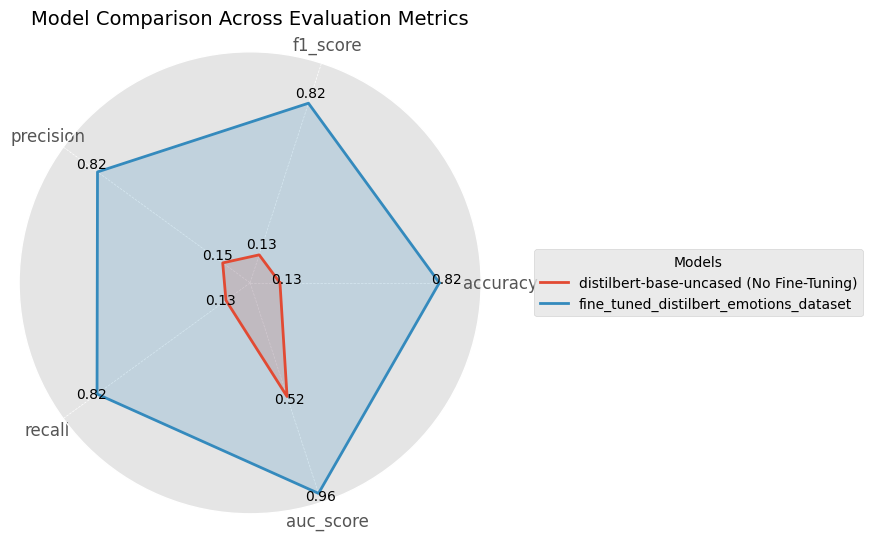

In [33]:
# Set up radar chart
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each model's results and annotate values
for model_name in model_names:
    values = [eval_results_dict[model_name][metric] for metric in metrics]
    values += values[:1]  # Close the loop

    ax.plot(angles, values, label=model_name, linewidth=2)
    ax.fill(angles, values, alpha=0.2)

    # Annotate values on the chart
    for angle, value in zip(angles[:-1], values[:-1]):  # Skip last duplicate point
        ax.text(angle, value + 0.03, f"{value:.2f}", ha='center', fontsize=10, color="black")

# Set x-axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)

# Remove y-axis labels (since values are annotated)
ax.set_yticks([])
ax.set_yticklabels([])

# Add grid lines for better readability
ax.grid(True, linestyle="--", linewidth=0.5)

# Title
ax.set_title('Model Comparison Across Evaluation Metrics', size=14, pad=20)

# Move legend outside the chart
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), title="Models", fontsize=10)

# Show the plot
plt.show()

## Explain Predictions

In this section, we'll use SHAP (SHapley Additive exPlanations) to provide interpretability and explain individual predictions.

The SHAP values help us understand the role of each token in driving the model's output.

In [34]:
ls fine_tuned_models/

fine_tuned_distilbert_emotions_dataset_trained_2025-12-30_19-22/


In [35]:
model_name

'fine_tuned_distilbert_emotions_dataset'

In [36]:
# Load in fine-tuned model
model_save_path = os.path.join(
    save_path,
    f"{model_name}_trained_{current_time}"
)

model_finetuned = AutoModelForSequenceClassification.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)


In [37]:
# Build a pipeline object for predictions
preds = pipeline(
    "text-classification",
    model=model_finetuned,
    tokenizer=tokenizer,
    return_all_scores=True,
)

# Create an explainer
explainer = shap.Explainer(preds)


### Test on Sentences

In [38]:
example_texts = [
    "The thought of speaking in front of a large crowd makes my heart race, and I start to feel overwhelmed with anxiety.",
    "I can't believe how disrespectful they were! I worked so hard on this project, and they just dismissed it without even listening. It's infuriating!",
    "I absolutely love this new phone! The camera quality is amazing, the battery lasts all day, and it's so fast. I couldn't be happier with my purchase, and I highly recommend it to anyone looking for a new phone.",
]

for i, text in enumerate(example_texts):
    print(f"Example {i}: ", "\n", text, "\n")

Example 0:  
 The thought of speaking in front of a large crowd makes my heart race, and I start to feel overwhelmed with anxiety. 

Example 1:  
 I can't believe how disrespectful they were! I worked so hard on this project, and they just dismissed it without even listening. It's infuriating! 

Example 2:  
 I absolutely love this new phone! The camera quality is amazing, the battery lasts all day, and it's so fast. I couldn't be happier with my purchase, and I highly recommend it to anyone looking for a new phone. 



In [39]:
def print_predicted_label(text):
    # Tokenize the text
    inputs = tokenizer(
        text,
        padding="longest",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Convert inputs to a dataset format
    input_data = Dataset.from_dict(inputs)

    # Make predictions
    predictions = trainer.predict(input_data)

    # Get the predicted class (the class with the highest logit value)
    predicted_class = predictions.predictions.argmax(axis=1).item()

    # Get the label corresponding to the predicted class
    predicted_label = id2label[predicted_class]

    return predicted_label

In [40]:
predicted_label_examples = [print_predicted_label(text) for text in example_texts]

for i, predicted_label in enumerate(predicted_label_examples):
    print(f"Example {i}, Predicted label: {predicted_label}")

Example 0, Predicted label: fear
Example 1, Predicted label: anger
Example 2, Predicted label: joy


In [41]:
shap_values_examples = explainer(example_texts)

PartitionExplainer explainer: 4it [00:10, 10.89s/it]               


In [42]:
shap.plots.text(shap_values_examples)

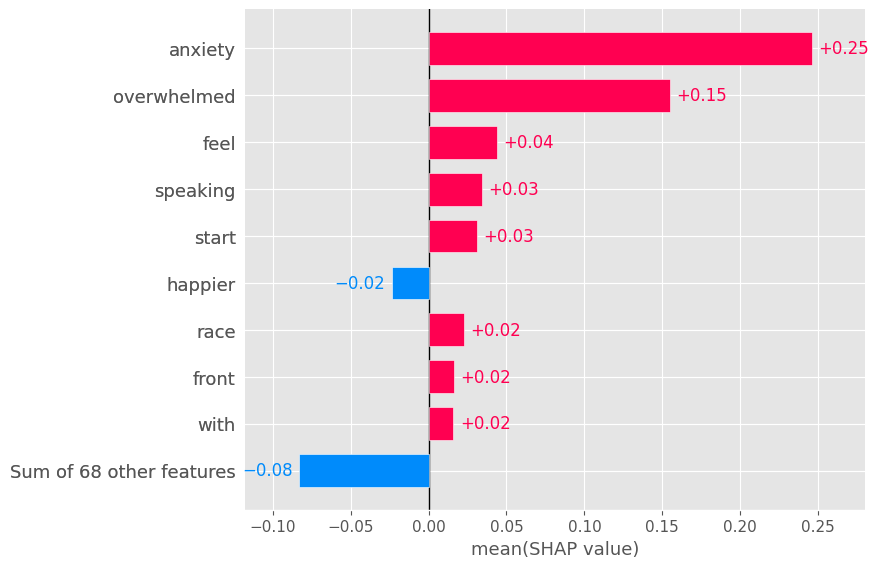

In [43]:
shap.plots.bar(shap_values_examples[:, :, "fear"].mean(0))

In [44]:
from google.colab import files
import shutil

shutil.make_archive("fine_tuned_models", "zip", "fine_tuned_models")
files.download("fine_tuned_models.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>